# Face Detection Using VGG16 and Tensorflow using Custom Data

## Poster
<img src="Screenshot 2023-06-14 225349.jpg">

In [107]:
# Folder Structure
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        # for f in files:
        #     print('{}{}'.format(subindent, f))
list_files("./")

/
aug_data/
    test/
        images/
        labels/
    train/
        images/
        labels/
    val/
        images/
        labels/
Data/
    images/
    labels/
    test/
        images/
        labels/
    train/
        images/
        labels/
    val/
        images/
        labels/
logs/
    train/
    validation/


## 1 Capture Images and Label

Use the generate_images.py to save the images in the specified folder.

## 2 Label Images with Labelme

In [59]:
!labelme

## 3 Review Data and Prepare Data Load Pipeline for Agumentation

### 3.1 Import Dependencies

In [1]:
import tensorflow as tf
import json
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

### 3.2 Load images in TF Dataset

In [60]:
images = tf.data.Dataset.list_files("Data\\test\\images\\*.jpg", shuffle=False)

In [61]:
images.as_numpy_iterator().next() # Before applying load_image map. Only returns the path

b'Data\\test\\images\\137.jpg'

In [62]:
def load_image(path):
    byte_image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(byte_image)
    return image

In [63]:
images = images.map(load_image)

In [64]:
images.as_numpy_iterator().next() # After mapping load_image function. Returns the ndarray of an image

array([[[255, 249, 255],
        [255, 248, 255],
        [254, 249, 255],
        ...,
        [252, 254, 251],
        [252, 254, 253],
        [253, 255, 254]],

       [[255, 248, 255],
        [255, 248, 255],
        [254, 249, 255],
        ...,
        [253, 255, 252],
        [253, 255, 254],
        [253, 255, 254]],

       [[254, 249, 255],
        [254, 249, 255],
        [254, 249, 253],
        ...,
        [253, 255, 254],
        [251, 255, 255],
        [251, 255, 255]],

       ...,

       [[119, 100,  96],
        [122, 103,  99],
        [115,  96,  92],
        ...,
        [168, 123, 128],
        [168, 125, 132],
        [171, 128, 135]],

       [[118,  99,  93],
        [119, 100,  94],
        [109,  90,  86],
        ...,
        [207, 158, 162],
        [190, 143, 149],
        [176, 131, 136]],

       [[117,  98,  92],
        [118,  99,  93],
        [110,  91,  87],
        ...,
        [222, 173, 177],
        [211, 162, 168],
        [196, 149, 155]]

### 3.3 Visualize images with Matplotlib

In [65]:
batch_image_generator = images.batch(4).as_numpy_iterator()

In [68]:
plot_images = batch_image_generator.next()

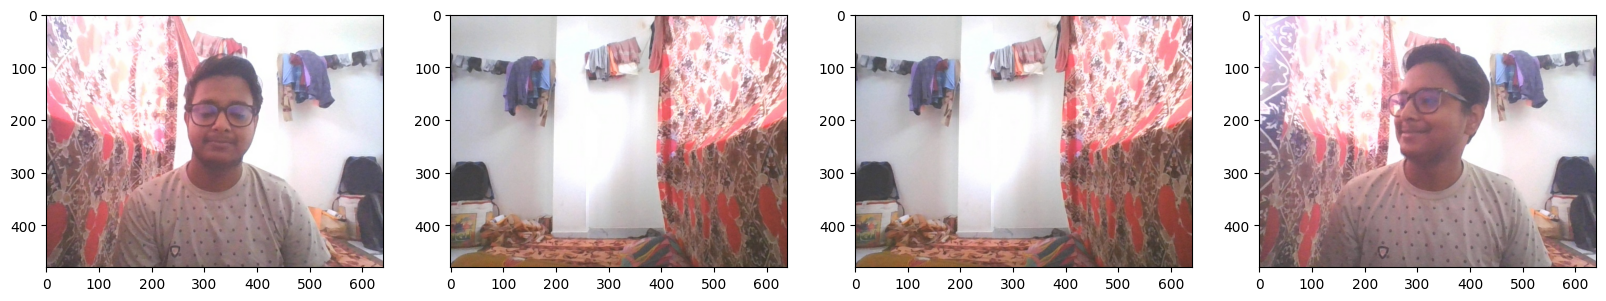

In [69]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i, image in enumerate(plot_images):
    ax[i].imshow(image)
plt.show()

## 4 Manually Split Data in train, test, val

In [46]:
# Assigning 60% for training and 20% for testing and validation

In [48]:
# train, test, valid
50*0.6, 50*0.2, 50*0.2

(30.0, 10.0, 10.0)

In [16]:
# Move according json files to respective folder
for folder in ["train", "test", "val"]:
    image_list = os.listdir(os.path.join("Data", folder, "images"))
    for image_name in image_list:
        json_name = image_name.split(".")[0]+".json"
        json_old_path = os.path.join("Data\labels", json_name)
        json_new_path = os.path.join("Data", folder, "labels", json_name)
        # print(json_old_path, json_new_path)
        if os.path.exists(json_old_path):
            os.replace(json_old_path, json_new_path)
            print(f"Moved {json_name} to {folder}")

Moved 00fb7e59-0b32-11ee-911c-983b8f98b434.json to train
Moved 01527c20-0b32-11ee-9cb5-983b8f98b434.json to train
Moved 14.json to train
Moved 168.json to train
Moved 26.json to train
Moved 40.json to train
Moved 54.json to train
Moved b7e0f542-0b31-11ee-95bc-983b8f98b434.json to train
Moved b893ca31-0b31-11ee-8206-983b8f98b434.json to train
Moved b93c13d8-0b31-11ee-b3e9-983b8f98b434.json to train
Moved b98cee09-0b31-11ee-97a6-983b8f98b434.json to train
Moved ba0f1dd5-0b31-11ee-ae54-983b8f98b434.json to train
Moved bc4c0d5b-0b31-11ee-9d2f-983b8f98b434.json to train
Moved bc9cd1c3-0b31-11ee-8cde-983b8f98b434.json to train
Moved bd435bc0-0b31-11ee-a82b-983b8f98b434.json to train
Moved bd99330b-0b31-11ee-af7d-983b8f98b434.json to train
Moved be3eca67-0b31-11ee-8af6-983b8f98b434.json to train
Moved be8fade1-0b31-11ee-b970-983b8f98b434.json to train
Moved bf8c0f05-0b31-11ee-8b0b-983b8f98b434.json to train
Moved c085d13c-0b31-11ee-9586-983b8f98b434.json to train
Moved c0d6d168-0b31-11ee-a9e5

## 5 Apply augmentation on images and labels

### 5.1 Import dependencies

In [72]:
import albumentations as alb

### 5.2 Start augmentation

In [70]:
cv2.imread("Data\\val\\images\\28.jpg").shape # Max pixel check. Cropping should be less than min 

(480, 640, 3)

In [73]:
augmentor = alb.Compose([alb.RandomCrop(height=450, width=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.5),
                         alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations',
                                                   label_fields=["class_labels"]))

In [74]:
img = cv2.imread("Data\\train\\images\\168.jpg")
img

array([[[255, 246, 255],
        [255, 246, 255],
        [254, 247, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [255, 255, 255]],

       [[255, 247, 255],
        [255, 247, 255],
        [255, 248, 255],
        ...,
        [254, 254, 254],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 247, 255],
        [255, 248, 255],
        [255, 249, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[ 91,  82, 102],
        [ 97,  89, 106],
        [ 87,  79,  96],
        ...,
        [163, 168, 217],
        [171, 175, 224],
        [175, 179, 228]],

       [[ 88,  80,  97],
        [ 93,  86, 101],
        [ 86,  81,  96],
        ...,
        [129, 132, 183],
        [123, 126, 177],
        [126, 129, 180]],

       [[ 89,  82,  97],
        [ 91,  84,  99],
        [ 89,  85,  97],
        ...,
        [139, 142, 193],
        [128, 131, 182],
        [131, 134, 185]]

In [83]:
with open("Data\\train\\labels\\168.json", "r") as f:
    label = json.load(f)

In [84]:
label

{'version': '5.2.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[225.32994923857865, 102.43654822335026],
    [474.06091370558374, 404.9746192893401]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {}}],
 'imagePath': '..\\images\\168.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVl

In [85]:
label["shapes"][0]["points"]

[[225.32994923857865, 102.43654822335026],
 [474.06091370558374, 404.9746192893401]]

In [86]:
coords = [0]*4
coords[0] = label["shapes"][0]["points"][0][0]
coords[1] = label["shapes"][0]["points"][0][1]
coords[2] = label["shapes"][0]["points"][1][0]
coords[3] = label["shapes"][0]["points"][1][1]
coords #x1, y1, x2, y2

[225.32994923857865, 102.43654822335026, 474.06091370558374, 404.9746192893401]

In [87]:
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.3520780456852791,
 0.21340947546531303,
 0.7407201776649746,
 0.8436971235194586]

In [88]:
augmented_image = augmentor(image=img, bboxes= [coords], class_labels=["face"])

In [89]:
augmented_image

{'image': array([[[ 92,  96, 150],
         [ 93,  96, 152],
         [ 95,  98, 156],
         ...,
         [ 95,  99, 107],
         [ 95,  99, 107],
         [ 95,  99, 107]],
 
        [[ 92,  96, 150],
         [ 92,  98, 153],
         [ 91,  96, 154],
         ...,
         [ 93,  98, 108],
         [ 92,  97, 107],
         [ 93,  98, 108]],
 
        [[ 94,  99, 151],
         [ 97, 103, 158],
         [ 97, 102, 160],
         ...,
         [ 93,  98, 108],
         [ 92,  97, 107],
         [ 93,  98, 108]],
 
        ...,
 
        [[243, 243, 238],
         [243, 243, 238],
         [243, 243, 238],
         ...,
         [244, 241, 238],
         [244, 241, 238],
         [241, 239, 238]],
 
        [[243, 243, 238],
         [243, 243, 238],
         [243, 243, 238],
         ...,
         [244, 241, 238],
         [244, 241, 238],
         [241, 240, 238]],
 
        [[243, 243, 238],
         [243, 243, 238],
         [243, 243, 238],
         ...,
         [244, 242,

In [90]:
augmented_image["bboxes"]

[(0.17986463620981386,
  0.1556119571347997,
  0.7326001128031585,
  0.8279187817258883)]

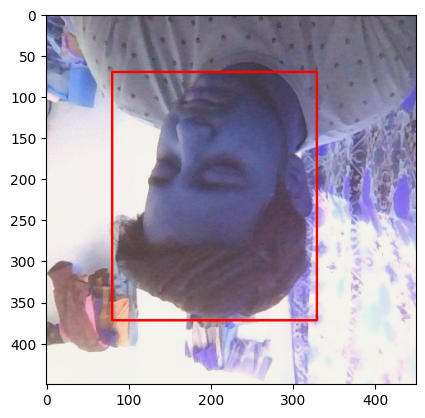

In [91]:
img = cv2.rectangle(augmented_image["image"], tuple(np.multiply(augmented_image["bboxes"][0][:2], [450,450]).astype(np.int32)),
                                tuple(np.multiply(augmented_image["bboxes"][0][2:], [450,450]).astype(np.int32)),
                                (255,0,0),2) # (image_array, (x_min, y_min), (x_max, y_max), rect_color, thickness)
plt.imshow(img)
plt.show()

## 6 Build and run Augmentation Pipeline

In [ ]:
augmentor = alb.Compose([alb.RandomCrop(height=450, width=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.5),
                         alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations',
                                                   label_fields=["class_labels"]))

In [78]:
for folder in ["train", "test", "val"]:
    images = os.listdir(os.path.join("Data", folder, "images"))
    for image in images:
        actual_image_path = os.path.join("Data", folder, "images", image)
        json_name = image.split(".")[0]+".json"
        json_path = os.path.join("Data", folder, "labels", json_name)
        img = cv2.imread(actual_image_path)
        coords = [0,0,0.000001,0.000001]
        print("Augmenting Image:" , actual_image_path)
        if os.path.exists(json_path):
            with open(json_path, "r") as f:
                label = json.load(f)
            coords[0] = label["shapes"][0]["points"][0][0]
            coords[1] = label["shapes"][0]["points"][0][1]
            coords[2] = label["shapes"][0]["points"][1][0]
            coords[3] = label["shapes"][0]["points"][1][1]
            
            coords = list(np.divide(coords, [640,480,640,480]))
        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes= [coords], class_labels=["face"])
                new_image_name = image.split(".")[0]+f"_{x}.jpg"
                new_image_path = os.path.join("aug_data", folder, "images", new_image_name)
                cv2.imwrite(new_image_path, augmented["image"])
                
                annotation = {}
                annotation["image"] = image
                if os.path.exists(json_path):
                    if len(augmented["bboxes"])==0:
                        annotation["bbox"] = [0,0,0,0]
                        annotation["class"] = 0
                    else:
                        annotation["bbox"] = augmented["bboxes"][0]
                        annotation["class"] = 1
                else:
                    annotation["bbox"] = [0,0,0,0]
                    annotation["class"] = 0
                
                new_json_path = os.path.join("aug_data", folder, "labels", new_image_name.split(".")[0]+".json")
                with open(new_json_path, "w") as f:
                    json.dump(annotation, f)
        except Exception as e:
            print(e)

Augmenting Image: Data\test\images\137.jpg
Augmenting Image: Data\test\images\150.jpg
Augmenting Image: Data\test\images\16.jpg
Augmenting Image: Data\test\images\171.jpg
Augmenting Image: Data\test\images\183.jpg
Augmenting Image: Data\test\images\2e4500d1-0cc3-11ee-8201-983b8f98b434.jpg
Augmenting Image: Data\test\images\2ebba2c2-0cc3-11ee-8c13-983b8f98b434.jpg
Augmenting Image: Data\test\images\37.jpg
Augmenting Image: Data\test\images\54.jpg
Augmenting Image: Data\test\images\60.jpg


In [79]:
for folder in ["train", "test", "val"]:
    for subs in ["images", "labels"]:
        filesc = len(os.listdir(os.path.join("aug_data", folder, subs)))
        print(f"{filesc} number of files in {folder}/{subs}")

1800 number of files in train/images
1800 number of files in train/labels
600 number of files in test/images
600 number of files in test/labels
600 number of files in val/images
600 number of files in val/labels


## 7 Load Augmented Images to TF

In [80]:
import tensorflow as tf
import json
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

In [81]:
def load_image(path):
    byte_image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(byte_image)
    return image

In [82]:
train_images = tf.data.Dataset.list_files("aug_data/train/images/*.jpg", shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [83]:
test_images = tf.data.Dataset.list_files("aug_data/test/images/*.jpg", shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [84]:
val_images = tf.data.Dataset.list_files("aug_data/val/images/*.jpg", shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

## 8 Prepare Labels

### 8.1 Build Loader Function

In [85]:
def load_lable(path):
    with open(path.numpy(), "r") as f:
        label = json.load(f)
    return [label["class"]], label["bbox"]

### 8.2 Load Labels

In [86]:
train_labels = tf.data.Dataset.list_files("aug_data/train/labels/*.json", shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_lable,[x], [tf.uint8, tf.float32]))

In [87]:
test_labels = tf.data.Dataset.list_files("aug_data/test/labels/*.json", shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_lable,[x], [tf.uint8, tf.float32]))

In [88]:
val_labels = tf.data.Dataset.list_files("aug_data/val/labels/*.json", shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_lable,[x], [tf.uint8, tf.float32]))

In [89]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.        , 0.736379  , 0.08082347, 1.        ], dtype=float32))

## 9 Combine Labels and Images

### 9.1 Check partition lengths

In [90]:
len(train_images), len(train_labels),len(test_images), len(test_labels),len(val_images), len(val_labels)

(1800, 1800, 600, 600, 600, 600)

### 9.2 Create final dataset

In [91]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [92]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [93]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [94]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [95]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.        , 0.        , 0.        , 0.        ],
        [0.311912  , 0.12187253, 0.6920587 , 0.69378453],
        [0.14752397, 0.16726452, 0.5265426 , 0.6218613 ],
        [0.17635646, 0.10631698, 0.5565031 , 0.678229  ],
        [0.17475465, 0.3536943 , 0.53459674, 0.7676819 ],
        [0.11031021, 0.24120699, 0.4701523 , 0.6551946 ],
        [0.3673999 , 0.16319233, 0.9201354 , 0.83549917],
        [0.2084828 , 0.13376199, 0.5344839 , 0.5770784 ]], dtype=float32))

### 9.3 Check some images

In [96]:
data_samples = test.as_numpy_iterator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


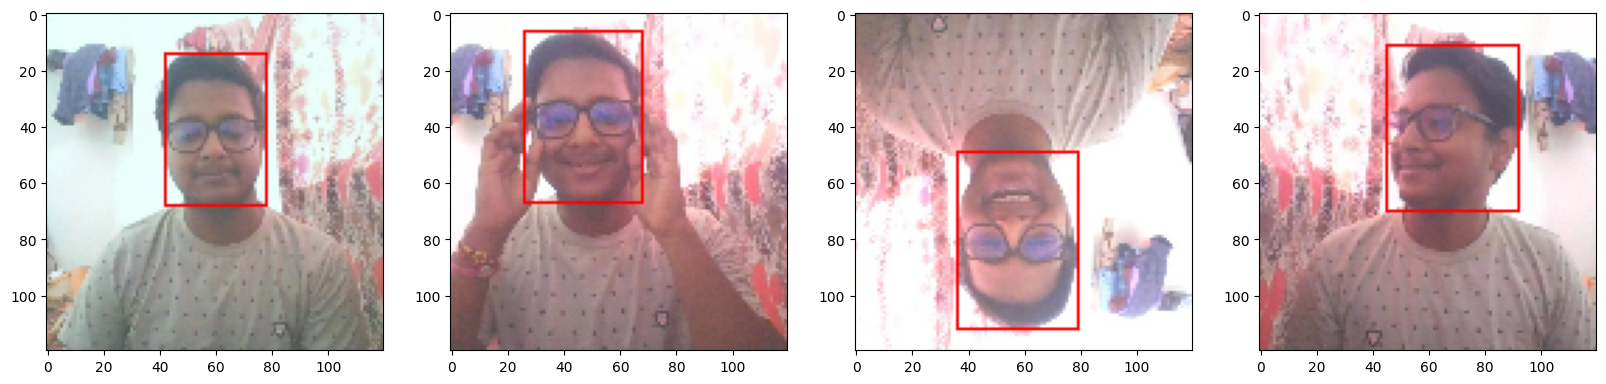

In [97]:
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i in range(4):
    img = res[0][i]
    coords = res[1][1][i]
    cv2.rectangle(img, tuple(np.multiply(coords[:2], [120,120]).astype(int)), tuple(np.multiply(coords[2:], [120,120]).astype(int)), (255,0,0), 1)
    ax[i].imshow(img)

In [19]:
res[1] # Sample outputs

(array([[0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.07097575, 0.189859  , 0.6237112 , 0.8621658 ],
        [0.21238579, 0.08409476, 0.59253246, 0.65600675],
        [0.4823463 , 0.3648054 , 0.8613649 , 0.81940216],
        [0.569013  , 0.38036096, 0.9480316 , 0.8349577 ],
        [0.25542018, 0.10672307, 0.80815566, 0.7790299 ],
        [0.        , 0.        , 0.        , 0.        ]], dtype=float32))

## 10 Build the model using Functional API

### 10.1 Import Dependencies For Base Model

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Add, GlobalMaxPool2D
from tensorflow.keras.applications import VGG16

### 10.2 Download and load VGG16

In [21]:
vgg = VGG16(include_top=False)

In [22]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 10.3 Build Model

In [23]:
def build_modle():
    input_layer = Input(shape = (120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)
    
    # Classification part
    f1 = GlobalMaxPool2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation = 'sigmoid')(class1)
    
    # Regression Part
    f2 = GlobalMaxPool2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation = 'sigmoid')(regress1)
    
    model = Model(inputs = input_layer, outputs = [class2, regress2])
    return model

In [24]:
basemodel = build_modle()

In [25]:
basemodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

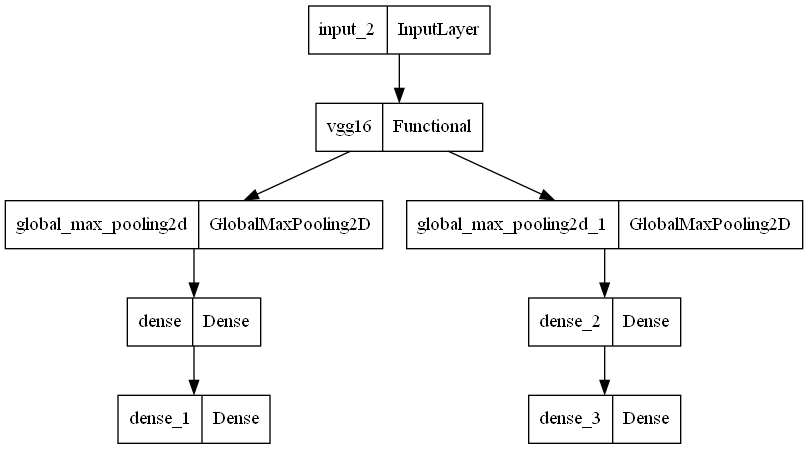

In [26]:
tf.keras.utils.plot_model(basemodel)

### 10.4 Test Pretrained VGG model

In [27]:
X, y = train.as_numpy_iterator().next()

In [28]:
yhat = basemodel.predict(X)

1/1 [==============================] - 7s 7s/step


In [29]:
yhat # Bad result as not trained.

[array([[0.44908276],
        [0.44478598],
        [0.5309154 ],
        [0.4858792 ],
        [0.47232795],
        [0.40557224],
        [0.45722562],
        [0.48676154]], dtype=float32),
 array([[0.4353089 , 0.680402  , 0.5554974 , 0.70660657],
        [0.38009837, 0.6275336 , 0.50193906, 0.6246906 ],
        [0.4337914 , 0.59010494, 0.59131366, 0.7068217 ],
        [0.40002477, 0.6205628 , 0.56193674, 0.7679164 ],
        [0.4057065 , 0.60226905, 0.51955813, 0.7478023 ],
        [0.41861767, 0.5970958 , 0.4609571 , 0.65817297],
        [0.357462  , 0.61859417, 0.55577856, 0.7062635 ],
        [0.4510881 , 0.60557395, 0.5071781 , 0.695293  ]], dtype=float32)]

## 11 Define Losses and Optimizers

### 11.1 Define Optimizer

In [30]:
len(train)

225

In [31]:
batches_per_epoch = len(train)
lr_decay = (1/0.75-1)/batches_per_epoch

In [32]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay = lr_decay)

### 11.2 Define Custom Loss Function

In [33]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    
    h_true = y_true[:,3] - y_true[:,1]
    h_pred = yhat[:,3] - yhat[:,1]
    
    w_true = y_true[:,2] - y_true[:,0]
    w_pred = yhat[:,2] - yhat[:,0]
    
    delta_size = tf.reduce_sum(tf.square(h_true - h_pred) + tf.square(w_true - w_pred))
    
    return delta_coord + delta_size

In [34]:
def calculate_iou(y_true, yhat):
    # Calculate coordinates of intersection rectangle
    x_min_inter = tf.maximum(y_true[:,0], yhat[:,0])
    y_min_inter = tf.maximum(y_true[:,1], yhat[:,1])
    x_max_inter = tf.minimum(y_true[:,2], yhat[:,2])
    y_max_inter = tf.minimum(y_true[:,3], yhat[:,3])
    
    # Calculate area of intersection rectangle
    intersection_area = tf.maximum(0.0, x_max_inter - x_min_inter) * tf.maximum(0.0, y_max_inter - y_min_inter)
    
    # Calculate area of both bounding boxes
    y_true_area = (y_true[:,2] - y_true[:,0]) * (y_true[:,3] - y_true[:,1])
    yhat_area = (yhat[:,2] - yhat[:,0]) * (yhat[:,3] - yhat[:,1])
    
    # Calculate union area by subtracting intersection area from the sum of both bounding boxes
    union_area = y_true_area + yhat_area - intersection_area + 1e-6
    
    intersection_area = tf.reduce_mean(intersection_area)
    union_area = tf.reduce_mean(union_area)
    # Calculate IoU
    iou = intersection_area / union_area
    
    
    return iou


In [35]:
classification_loss = tf.keras.losses.BinaryCrossentropy()
reg_loss = localization_loss

### 11.3 Loss Function test

In [36]:
reg_loss(y[1], yhat[1])

<tf.Tensor: shape=(), dtype=float32, numpy=3.2056885>

In [37]:
classification_loss(y[0], yhat[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.7173067>

## 12 Create FaceTracker Class inherit from Model class of tf

In [38]:
class FaceTracker(Model):
    def __init__(self, facetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = facetracker
    
    def compile(self, optimizer, classloss, regloss, ioufunc, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer
        self.closs = classloss
        self.rloss = regloss
        self.iou = ioufunc
    
    def train_step(self, batch, **kwargs):
        X, y = batch
        
        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)
            
            batch_closs = self.closs(y[0], classes)
            batch_rloss = self.rloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = 0.5*batch_closs + batch_rloss # 0.5 is a just random number.
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)

            iouloss = self.iou(tf.cast(y[1], tf.float32), tf.cast(coords, tf.float32))
            
        self.optimizer.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total loss": total_loss, "closs": batch_closs, "rloss": batch_rloss, "IoU": iouloss}
    def test_step(self, batch, **kwargs):
        X,y = batch
        classes, coords = self.model(X, training=False)
        batch_closs = self.closs(y[0], classes)
        batch_rloss = self.rloss(tf.cast(y[1], tf.float32), coords)
        iouloss = self.iou(tf.cast(y[1], tf.float32), coords)
        total_loss = 0.5*batch_closs + batch_rloss # 0.5 is a just random number.
        return {"total loss": total_loss, "closs": batch_closs, "rloss": batch_rloss, "IoU": iouloss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [104]:
model = FaceTracker(basemodel)

In [115]:
model.compile(optimizer=optimizer, classloss=classification_loss, regloss = localization_loss, ioufunc=calculate_iou)

## 13 Train Model

In [116]:
log_dir = "logs"

In [117]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [ ]:
hist = model.fit(train, epochs = 100, validation_data=val, callbacks=[tensorboard_callback])

In [ ]:
basemodel.save("last_100epochs.h5")

## 14 Test Saved Model

In [98]:
bestmodel = tf.keras.models.load_model("last_100epochs.h5")

In [99]:
bestmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [100]:
test_iterator = test.as_numpy_iterator()

1/1 [==============================] - 0s 423ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.2898511  0.29794496 0.7139235  0.88345593]
[0.33730903 0.10862588 0.7682153  0.7269816 ]
[0.3380543  0.29320148 0.7955585  0.8896371 ]
[0.1563738  0.07036038 0.5628185  0.60379094]
[0.18405461 0.35213    0.5638539  0.91173434]


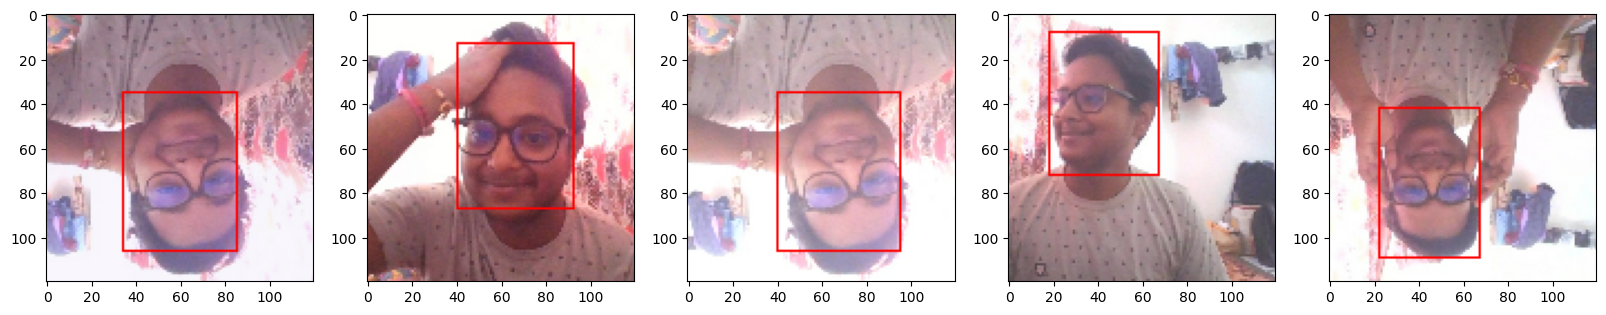

In [105]:
X,y = test_iterator.next()
pred = bestmodel.predict(X)
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for i in range(5):
    img = X[i]
    coords = pred[1][i]
    prob = pred[0][i][0]
    print(coords)
    if prob>0.5:
        cv2.rectangle(img, tuple(np.multiply(coords[:2], [120,120]).astype(int)), tuple(np.multiply(coords[2:], [120,120]).astype(int)), (255,0,0), 1)
        ax[i].imshow(img)